<a href="https://colab.research.google.com/github/MuhamedAdemi/Brainster-Python/blob/main/HomeWork9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Create a SimpleRNN and LSTM univariate model for the target column 'Open'.
2. Create a multivariate SimpleRNN and LSTM model for the target open, by using "Low", "High", and "Open" as features. (given t, predict t+1)

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# ========================
# SECTION 1: IMPORT LIBRARIES
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [5]:
# ========================
# SECTION 2: CONFIGURATION SETTINGS
# ========================
# Centralized configuration for easy parameter tuning
CONFIG = {
    'lookback': 60,         # Number of previous days to consider for prediction
    'epochs': 100,           # Maximum training cycles
    'batch_size': 32,        # Data samples processed per training step
    'units': [64, 32],       # Neurons in each RNN layer [layer1, layer2]
    'dropout': 0.2,          # Fraction of neurons to disable during training (prevents overfitting)
    'validation_split': 0.2, # Fraction of training data used for validation
    'target': 'Open',        # The stock price we want to predict
    'features': {            # Different feature sets for each model type
        'univariate': ['Open'],  # Only historical Open prices
        'multivariate': ['Low', 'High', 'Open']  # Multiple market indicators
    },
    'base_path': "/content/drive/MyDrive/Machine Learning/Instructions & data"
}


In [7]:
# ========================
# SECTION 3: DATA LOADING
# ========================
# Load training and test datasets from CSV files
train_df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Instructions & data/Google_Stock_Price_Train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Instructions & data/Google_Stock_Price_Test.csv")


In [8]:
# ========================
# SECTION 4: DATA PREPARATION FUNCTION
# ========================
def prepare_data(train_df, test_df, lookback, features, target):
    """
    Prepares time-series data for modeling by:
    1. Combining train/test for consistent scaling
    2. Applying Min-Max scaling (0-1 range)
    3. Creating input sequences (X) and target values (y)
    4. Splitting into proper train/test sets

    Returns: X_train, y_train, X_test, y_test, scaler
    """
    # Combine datasets for consistent scaling
    combined = pd.concat([train_df[features], test_df[features]], axis=0)

    # Scale features to 0-1 range
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(combined)

    # Create input sequences and target values
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        # Input sequence: lookback days of features
        X.append(scaled_data[i-lookback:i])
        # Target: next day's opening price
        y.append(scaled_data[i, features.index(target)])

    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)

    # Split into train and test sets
    test_size = len(test_df)
    X_train = X[:-test_size]  # All data except last test_size points
    y_train = y[:-test_size]  # All targets except last test_size points
    X_test = X[-test_size:]   # Last test_size points
    y_test = y[-test_size:]   # Last test_size targets

    return X_train, y_train, X_test, y_test, scaler


In [9]:
# ========================
# SECTION 5: MODEL BUILDING FUNCTION
# ========================
def build_model(model_type, input_shape, units, dropout):
    """
    Constructs either a SimpleRNN or LSTM model with:
    - Two recurrent layers
    - Dropout regularization
    - Dense output layer

    Returns compiled Keras model
    """
    model = Sequential()

    # First RNN layer (returns sequences for next layer)
    if model_type == 'LSTM':
        model.add(LSTM(units=units[0], return_sequences=True,
                      input_shape=input_shape))
    else:  # SimpleRNN
        model.add(SimpleRNN(units=units[0], return_sequences=True,
                           input_shape=input_shape))
    model.add(Dropout(dropout))  # Randomly disable neurons

    # Second RNN layer (doesn't return sequences)
    if model_type == 'LSTM':
        model.add(LSTM(units=units[1]))
    else:  # SimpleRNN
        model.add(SimpleRNN(units=units[1]))
    model.add(Dropout(dropout))

    # Output layer (single value prediction)
    model.add(Dense(units=1))

    # Compile with Adam optimizer and MSE loss
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [10]:
# ========================
# SECTION 6: TRAINING & EVALUATION FUNCTION
# ========================
def train_and_evaluate(model, X_train, y_train, X_test, y_test, scaler,
                       features, target, model_name):
    """
    Trains model with early stopping and learning rate reduction
    Evaluates performance and visualizes results
    """
    # Setup training callbacks
    callbacks = [
        # Stop training if validation loss doesn't improve for 10 epochs
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        # Reduce learning rate when validation loss plateaus
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    ]

    # Train model with validation split
    print(f"\nTraining {model_name} model...")
    history = model.fit(
        X_train, y_train,
        epochs=CONFIG['epochs'],
        batch_size=CONFIG['batch_size'],
        validation_split=CONFIG['validation_split'],
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Generate predictions
    predictions = model.predict(X_test)

    # Inverse transform predictions to original price scale
    target_index = features.index(target)
    dummy_array = np.zeros((len(predictions), len(features)))
    dummy_array[:, target_index] = predictions[:, 0]
    predicted_prices = scaler.inverse_transform(dummy_array)[:, target_index]

    # Inverse transform actual test values
    dummy_array[:, target_index] = y_test
    actual_prices = scaler.inverse_transform(dummy_array)[:, target_index]

    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
    print(f"{model_name} RMSE: {rmse:.4f}")

    # Visualize predictions vs actual prices
    plt.figure(figsize=(12, 6))
    plt.plot(actual_prices, color='red', label='Actual Price')
    plt.plot(predicted_prices, color='blue', label='Predicted Price')
    plt.title(f'{model_name} Predictions')
    plt.xlabel('Trading Days')
    plt.ylabel('Stock Price ($)')
    plt.legend()
    plt.show()

    return rmse, actual_prices, predicted_prices



STARTING UNIVARIATE SIMPLERNN MODEL

Training Univariate SimpleRNN model...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.1526 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0373 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0253 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0154 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0137 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0105 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0105 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0077 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0071 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 10/100
30/30 ━━━

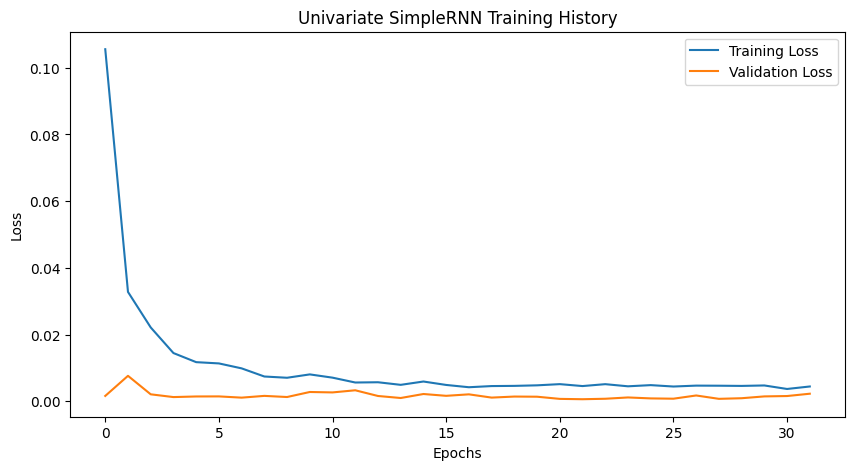

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Univariate SimpleRNN RMSE: 15.9261


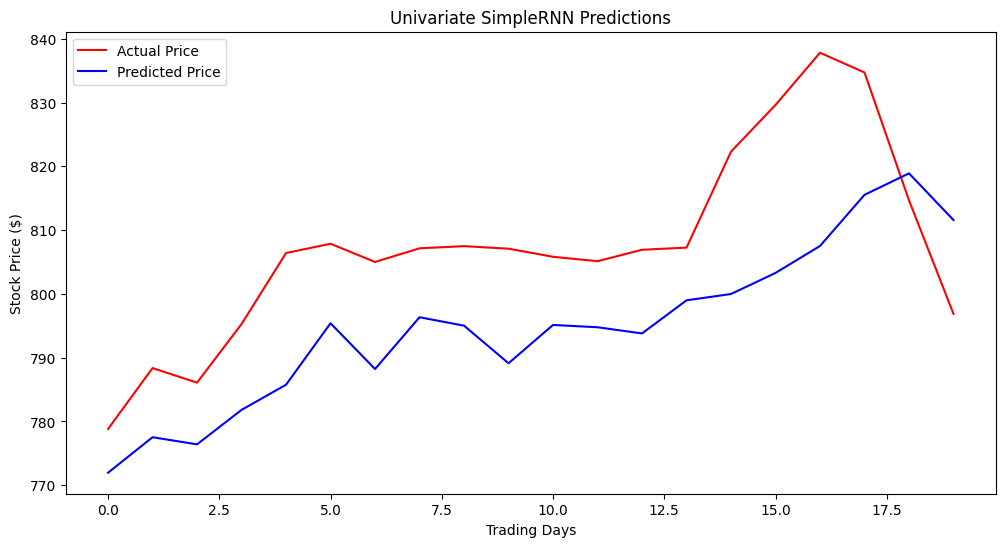


STARTING UNIVARIATE LSTM MODEL

Training Univariate LSTM model...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.0666 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0058 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0041 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0037 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0033 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0033 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0028 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0031 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0029 - val_loss: 0.0013 - learning_rate: 2.0000e-04
Epoch 10/100
30/3

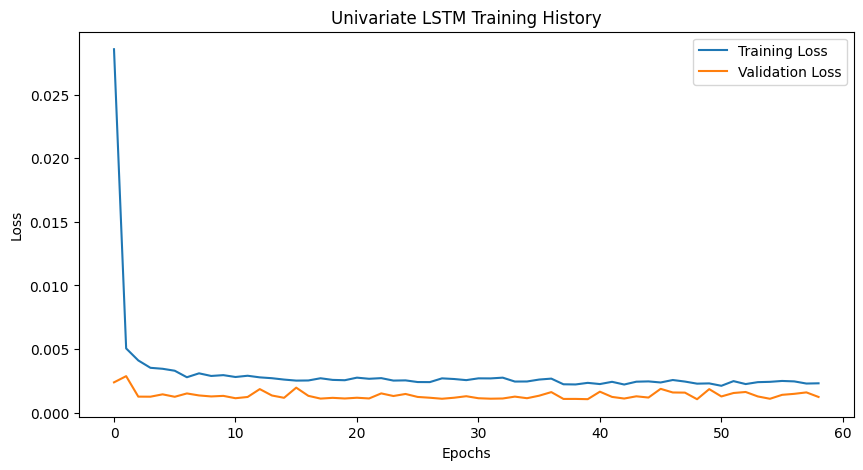

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Univariate LSTM RMSE: 16.9787


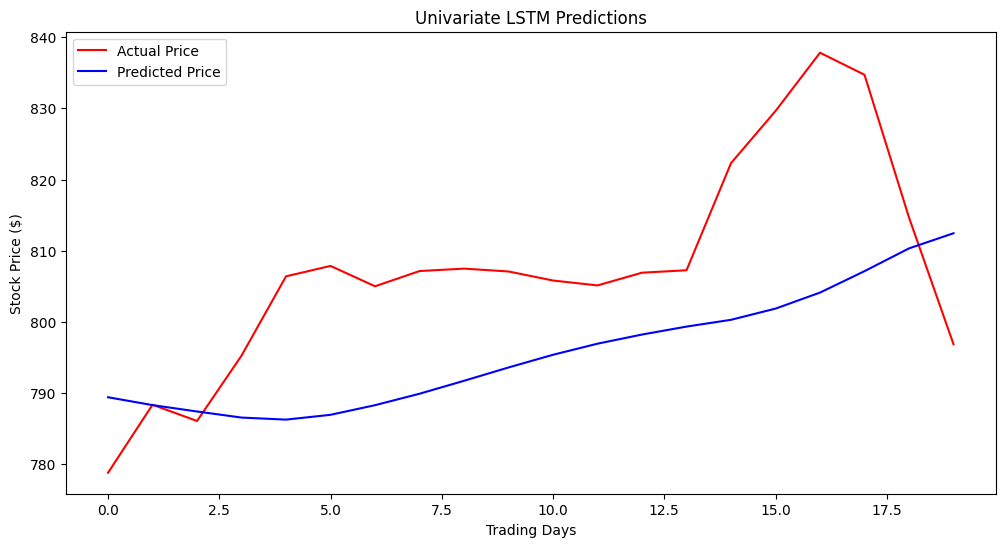


STARTING MULTIVARIATE SIMPLERNN MODEL

Training Multivariate SimpleRNN model...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.1987 - val_loss: 0.0341 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0549 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0334 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0254 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0235 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0151 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0132 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0106 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0106 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 10/100
30/30 ━━━

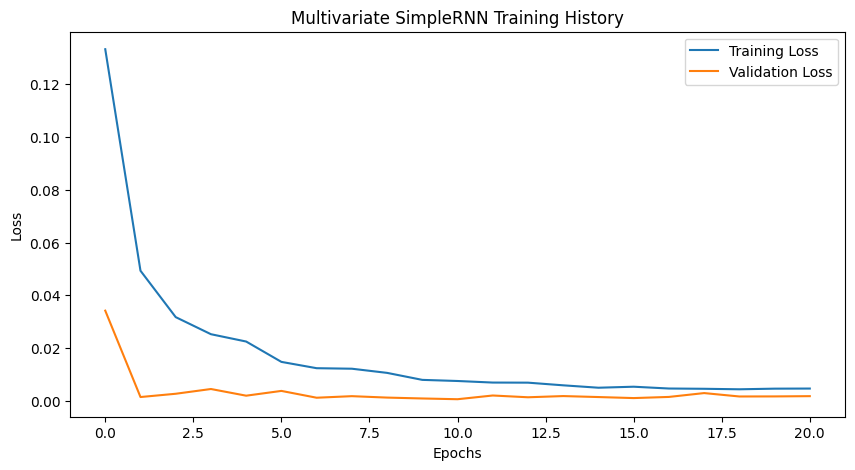

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Multivariate SimpleRNN RMSE: 14.2188


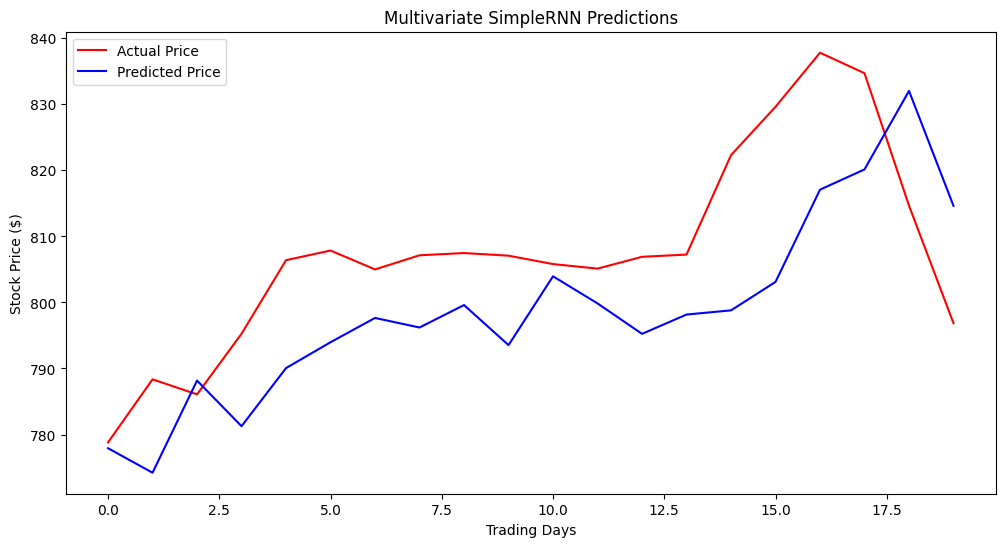


STARTING MULTIVARIATE LSTM MODEL

Training Multivariate LSTM model...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0640 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0054 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0035 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0031 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0032 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0036 - val_loss: 9.7845e-04 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0027 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0028 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0028 - val_loss: 0.0013 - learning_rate: 2.0000e-04
Epoch 10/100


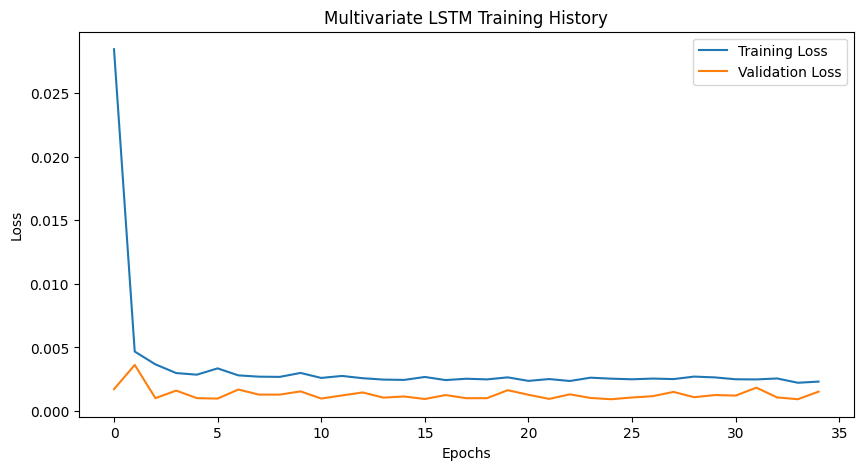

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Multivariate LSTM RMSE: 16.4197


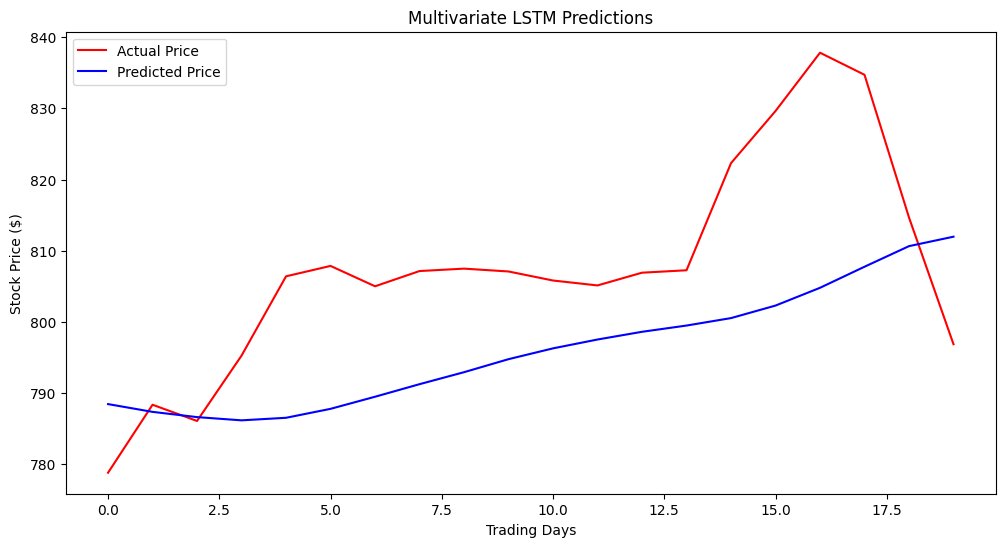

In [11]:
# ========================
# SECTION 7: MAIN EXECUTION - TRAIN ALL MODELS
# ========================
# Store results for comparison
results = []

# Define model types to train
model_types = ['SimpleRNN', 'LSTM']
data_types = ['univariate', 'multivariate']

for data_type in data_types:
    # Select features based on model type
    features = CONFIG['features'][data_type]

    # Prepare data for current model type
    X_train, y_train, X_test, y_test, scaler = prepare_data(
        train_df, test_df,
        CONFIG['lookback'],
        features,
        CONFIG['target']
    )

    for model_type in model_types:
        # Create model name for tracking
        model_name = f"{data_type.capitalize()} {model_type}"
        print(f"\n{'='*70}")
        print(f"STARTING {model_name.upper()} MODEL")
        print(f"{'='*70}")

        # Build model architecture
        model = build_model(
            model_type,
            (X_train.shape[1], X_train.shape[2]),  # Input shape (timesteps, features)
            CONFIG['units'],
            CONFIG['dropout']
        )

        # Train and evaluate model
        rmse, actual, predicted = train_and_evaluate(
            model, X_train, y_train, X_test, y_test, scaler,
            features, CONFIG['target'], model_name
        )

        # Store results for comparison
        results.append({
            'Model': model_name,
            'RMSE': rmse,
            'Actual': actual,
            'Predicted': predicted
        })




=== FINAL MODEL COMPARISON ===
                    Model       RMSE
2  Multivariate SimpleRNN  14.218831
0    Univariate SimpleRNN  15.926069
3       Multivariate LSTM  16.419714
1         Univariate LSTM  16.978714


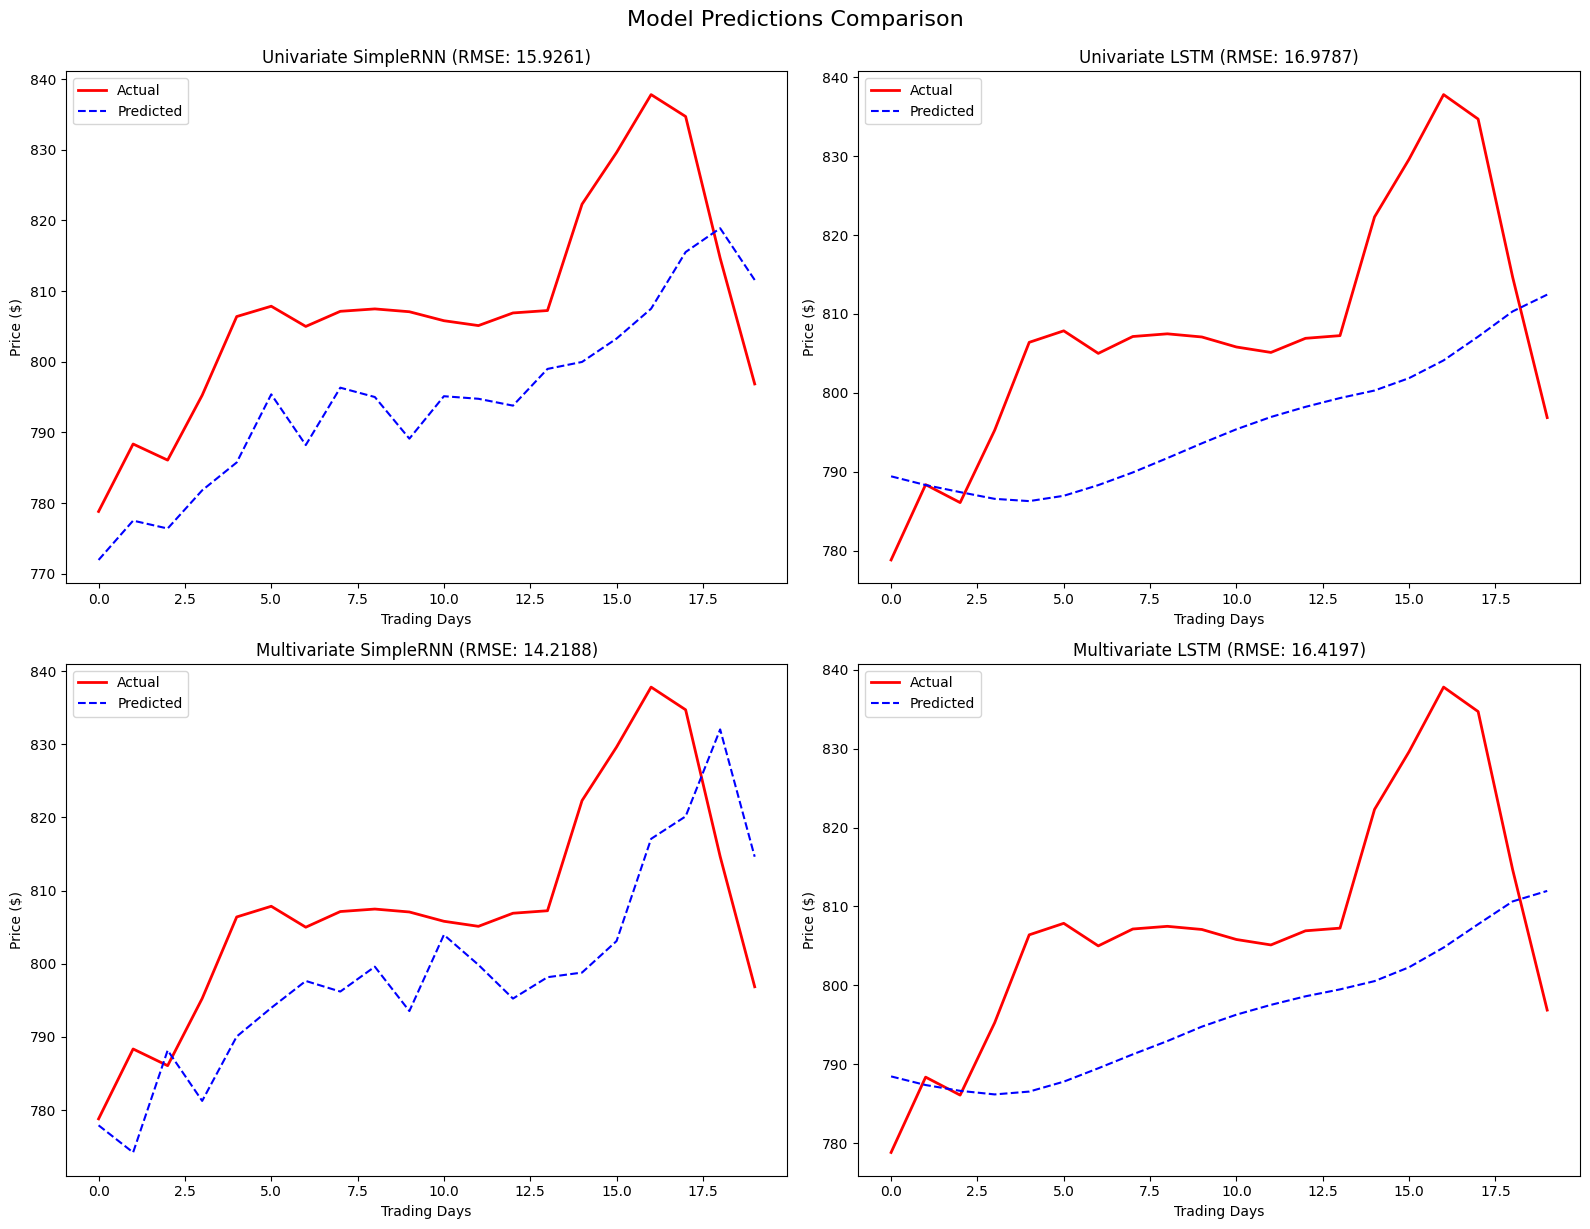

<ipython-input-12-1391598316>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=comparison_df, palette='viridis')


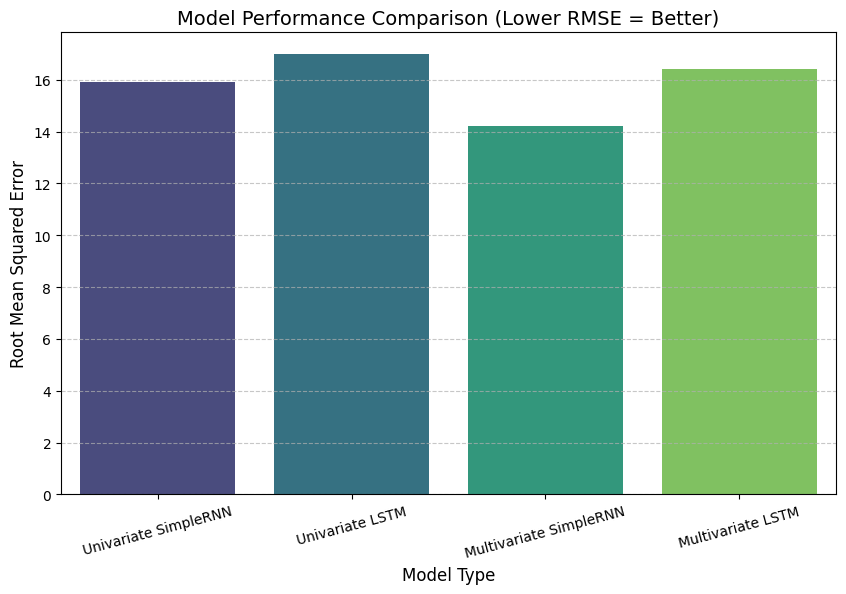


BEST PERFORMING MODEL: Multivariate SimpleRNN with RMSE: 14.2188


In [12]:
# ========================
# SECTION 8: RESULTS COMPARISON
# ========================
print("\n\n=== FINAL MODEL COMPARISON ===")

# Create comparison table
comparison_df = pd.DataFrame([(r['Model'], r['RMSE']) for r in results],
                            columns=['Model', 'RMSE'])
print(comparison_df.sort_values('RMSE'))

# Visualize all model predictions
plt.figure(figsize=(16, 12))
for i, result in enumerate(results):
    plt.subplot(2, 2, i+1)
    plt.plot(result['Actual'], 'r-', linewidth=2, label='Actual')
    plt.plot(result['Predicted'], 'b--', linewidth=1.5, label='Predicted')
    plt.title(f"{result['Model']} (RMSE: {result['RMSE']:.4f})")
    plt.xlabel('Trading Days')
    plt.ylabel('Price ($)')
    plt.legend()
plt.tight_layout()
plt.suptitle('Model Predictions Comparison', fontsize=16, y=1.02)
plt.show()

# Create RMSE comparison chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=comparison_df, palette='viridis')
plt.title('Model Performance Comparison (Lower RMSE = Better)', fontsize=14)
plt.xlabel('Model Type', fontsize=12)
plt.ylabel('Root Mean Squared Error', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print best model
best_model = comparison_df.loc[comparison_df['RMSE'].idxmin()]
print(f"\nBEST PERFORMING MODEL: {best_model['Model']} with RMSE: {best_model['RMSE']:.4f}")

Goal of the Notebook Iproved version
✅ Predict the stock price 'Open' column
✅ Use both SimpleRNN and LSTM models
✅ Apply both univariate and multivariate inputs
✅ Predict (given t ➝ predict t+1)
✅ Include model saving, EarlyStopping, and advanced features like Bidirectional LSTM

In [25]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [26]:
#2. Load Data from Google Drive
# Mount Google Drive first (only needs to be done once per Colab session)
from google.colab import drive
drive.mount('/content/drive')

# Set base path to your Google Drive project folder
base_path = "/content/drive/MyDrive/Machine Learning/Instructions & data/"

# Load training and testing datasets
train_path = base_path + "Google_Stock_Price_Train.csv"
test_path = base_path + "Google_Stock_Price_Test.csv"

import pandas as pd

# Read CSVs
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Show first few rows of training data
train_df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [27]:
#3. Prepare Data (Univariate + Multivariate)
# a. Scale 'Open' for Univariate
scaler_uni = MinMaxScaler()
train_open_scaled = scaler_uni.fit_transform(train_df[['Open']].values)
test_open = test_df[['Open']].values


In [28]:
#b. Scale ['Open', 'High', 'Low'] for Multivariate
features = ['Open', 'High', 'Low']
scaler_multi = MinMaxScaler()
train_multi_scaled = scaler_multi.fit_transform(train_df[features].values)
test_multi = test_df[features].values


In [29]:
#4. Create Sequences for Time Series
# a. Helper Function
def create_sequences(data, lookback, target_column=0):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i, target_column])
    return np.array(X), np.array(y)


In [30]:
# b. Prepare:
lookback = 60

X_uni, y_uni = create_sequences(train_open_scaled, lookback)
X_multi, y_multi = create_sequences(train_multi_scaled, lookback)


In [31]:
# 5. Define & Train Models
# a. Univariate SimpleRNN
model_uni_rnn = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(X_uni.shape[1], 1)),
    Dropout(0.2),
    SimpleRNN(50, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(50),
    Dropout(0.2),
    Dense(1)
])
model_uni_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_uni_rnn.fit(X_uni, y_uni, epochs=100, batch_size=32)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.3642
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.2027
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1203
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0757
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0549
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0418
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0341
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0239
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0244
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0201
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0189
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0166
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0151
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0132
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0115
E

In [32]:
# b. Univariate LSTM
model_uni_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_uni.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model_uni_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_uni_lstm.fit(X_uni, y_uni, epochs=100, batch_size=32)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0791
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0075
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0052
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0047
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0048
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0040
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0040
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0042
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0037
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0037
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0039
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0036
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0034
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0044
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step 

In [33]:
#c. Multivariate LSTM (Bidirectional + Saving)
model_path = base_path + "best_multivariate_lstm.h5"

model_multi_lstm = Sequential([
    Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_multi.shape[1], X_multi.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(50, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(50)),
    Dropout(0.3),
    Dense(1)
])

model_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='loss')

model_multi_lstm.fit(X_multi, y_multi, epochs=100, batch_size=32, callbacks=[early_stop, checkpoint])


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0685

38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - loss: 0.0675
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.0068

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - loss: 0.0068
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0048

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.0048
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0046

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.0046
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.0046

38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step - loss: 0.0046
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.0041

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - loss: 0.0041
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - loss: 0.0049
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - loss: 0.0041
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.0033

38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - loss: 0.0033
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - loss: 0.0032
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.0035
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.0033

38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - loss: 0.0033
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - loss: 0.0033
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0033

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.0033
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - loss: 0.0037
Epoch 16/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0032

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - loss: 0.0032
Epoch 17/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0030

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - loss: 0.0030
Epoch 18/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - loss: 0.0035
Epoch 19/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0027

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - loss: 0.0027
Epoch 20/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0025

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0025
Epoch 21/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0026

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - loss: 0.0026
Epoch 22/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - loss: 0.0026
Epoch 23/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - loss: 0.0031
Epoch 24/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 0.0046
Epoch 25/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0021

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 0.0021
Epoch 26/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 0.0028
Epoch 27/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - loss: 0.0027
Epoch 28/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.0024
Epoch 29/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - loss: 0.0026
Epoch 30/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - loss: 0.0023
Epoch 31/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - loss: 0.0026
Epoch 32/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - loss: 0.0023
Epoch 33/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - loss: 0.0023
Epoch 34/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - loss: 0.0024
Epoch 35/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - loss: 0.0022


In [34]:
#d. Multivariate SimpleRNN
model_multi_rnn = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(X_multi.shape[1], X_multi.shape[2])),
    Dropout(0.2),
    SimpleRNN(50, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(50),
    Dropout(0.2),
    Dense(1)
])
model_multi_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_multi_rnn.fit(X_multi, y_multi, epochs=100, batch_size=32)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.3407
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1369
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0919
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0760
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0525
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0487
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0337
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0293
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0254
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0230
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0214
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0162
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0164
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0132
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - lo

In [38]:
#6. Prepare Test Data and Predict
# Use combined data for multivariate
total_data = pd.concat((train_df[features], test_df[features]), axis=0)
inputs = total_data[len(total_data) - len(test_df) - lookback:].values
inputs_scaled = scaler_multi.transform(inputs)

X_test = []
for i in range(lookback, len(inputs_scaled)):
    X_test.append(inputs_scaled[i-lookback:i])
X_test = np.array(X_test)

# Load best model
best_model = load_model(model_path)

predicted_open = best_model.predict(X_test)
# Reconstruct shape for inverse transform
predicted_full = np.zeros((predicted_open.shape[0], len(features)))
predicted_full[:, 0] = predicted_open[:, 0]
predicted_open_real = scaler_multi.inverse_transform(predicted_full)[:, 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


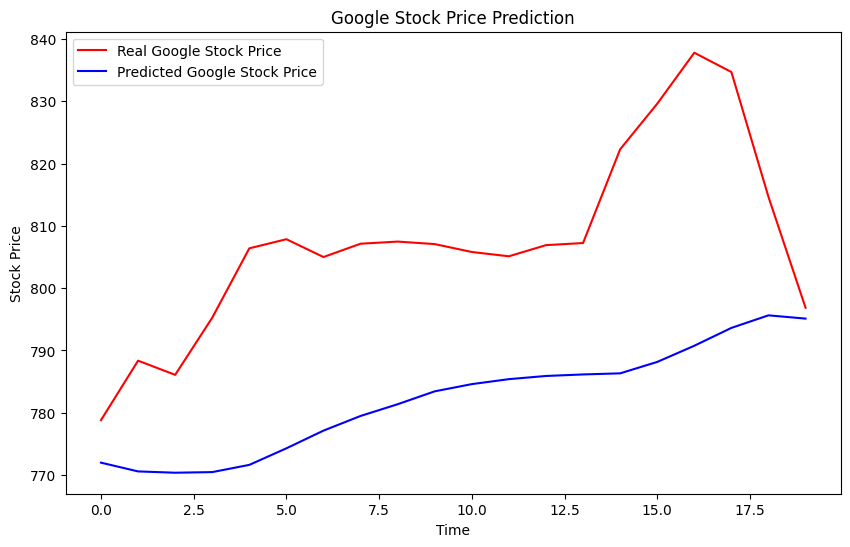

In [36]:
#7. Plot Results
real_open = test_df['Open'].values

plt.figure(figsize=(10,6))
plt.plot(real_open, color='red', label='Real Google Stock Price')
plt.plot(predicted_open_real, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [37]:
#8. Evaluate the Model
rmse = np.sqrt(mean_squared_error(real_open, predicted_open_real))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 27.705597935446043


Final Edition

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set base path
base_path = "/content/drive/MyDrive/Machine Learning/Instructions & data/"

# Load datasets
train_df = pd.read_csv(base_path + "Google_Stock_Price_Train.csv")
test_df = pd.read_csv(base_path + "Google_Stock_Price_Test.csv")

# Data preprocessing
def prepare_data(train_df, test_df, lookback, features, target):
    # Combine datasets for consistent scaling
    combined = pd.concat([train_df[features], test_df[features]], axis=0)

    # Scale features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(combined)

    # Create sequences
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i])
        y.append(scaled_data[i, features.index(target)])

    # Convert to arrays
    X, y = np.array(X), np.array(y)

    # Split into train and test
    test_size = len(test_df)
    X_train = X[:-test_size]
    y_train = y[:-test_size]
    X_test = X[-test_size:]
    y_test = y[-test_size:]

    return X_train, y_train, X_test, y_test, scaler

# Model building
def build_model(model_type, input_shape, units=50, dropout=0.2):
    model = Sequential()

    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(units, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(SimpleRNN(units, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(SimpleRNN(units))
        model.add(Dropout(dropout))

    elif model_type == 'LSTM':
        model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(LSTM(units, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(units))
        model.add(Dropout(dropout))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Model training and evaluation
def train_and_evaluate(model, X_train, y_train, X_test, y_test, scaler, features, target, model_name):
    # Setup callbacks
    checkpoint = ModelCheckpoint(
        f"{model_name}.h5",
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Load best model
    model.load_weights(f"{model_name}.h5")

    # Make predictions
    predictions = model.predict(X_test)

    # Inverse transform predictions
    target_index = features.index(target)
    dummy_array = np.zeros((len(predictions), len(features)))
    dummy_array[:, target_index] = predictions.flatten()
    predicted_prices = scaler.inverse_transform(dummy_array)[:, target_index]

    # Get actual values
    dummy_array[:, target_index] = y_test
    actual_prices = scaler.inverse_transform(dummy_array)[:, target_index]

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
    print(f"{model_name} RMSE: {rmse:.4f}")

    # Visualize predictions
    plt.figure(figsize=(12, 6))
    plt.plot(actual_prices, color='red', label='Actual Price')
    plt.plot(predicted_prices, color='blue', label='Predicted Price')
    plt.title(f'{model_name} Predictions')
    plt.xlabel('Trading Days')
    plt.ylabel('Stock Price ($)')
    plt.legend()
    plt.show()

    return rmse, actual_prices, predicted_prices

# Configuration
LOOKBACK = 60
UNIVARIATE_FEATURES = ['Open']
MULTIVARIATE_FEATURES = ['Low', 'High', 'Open']
TARGET = 'Open'

# Prepare data
X_uni_train, y_uni_train, X_uni_test, y_uni_test, scaler_uni = prepare_data(
    train_df, test_df, LOOKBACK, UNIVARIATE_FEATURES, TARGET
)

X_multi_train, y_multi_train, X_multi_test, y_multi_test, scaler_multi = prepare_data(
    train_df, test_df, LOOKBACK, MULTIVARIATE_FEATURES, TARGET
)

# Build and train models
models = {
    'univariate_simplernn': ('SimpleRNN', (X_uni_train.shape[1], 1)),
    'univariate_lstm': ('LSTM', (X_uni_train.shape[1], 1)),
    'multivariate_simplernn': ('SimpleRNN', (X_multi_train.shape[1], len(MULTIVARIATE_FEATURES))),
    'multivariate_lstm': ('LSTM', (X_multi_train.shape[1], len(MULTIVARIATE_FEATURES)))
}

results = {}

for model_name, (model_type, input_shape) in models.items():
    print(f"\n\n=== STARTING {model_name.upper()} MODEL ===")

    # Select appropriate dataset
    if 'univariate' in model_name:
        X_train, y_train, X_test, y_test, scaler = X_uni_train, y_uni_train, X_uni_test, y_uni_test, scaler_uni
        features = UNIVARIATE_FEATURES
    else:
        X_train, y_train, X_test, y_test, scaler = X_multi_train, y_multi_train, X_multi_test, y_multi_test, scaler_multi
        features = MULTIVARIATE_FEATURES

    # Build model
    model = build_model(model_type, input_shape)

    # Train and evaluate
    rmse, actual, predicted = train_and_evaluate(
        model, X_train, y_train, X_test, y_test,
        scaler, features, TARGET, model_name
    )

    # Store results
    results[model_name] = {
        'rmse': rmse,
        'actual': actual,
        'predicted': predicted
    }

# Compare all models
print("\n\n=== FINAL RESULTS COMPARISON ===")
for model_name, result in results.items():
    print(f"{model_name.upper()}: RMSE = {result['rmse']:.4f}")

# Visual comparison of all predictions
plt.figure(figsize=(15, 10))
for i, (model_name, result) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    plt.plot(result['actual'], color='red', label='Actual Price')
    plt.plot(result['predicted'], color='blue', label='Predicted Price')
    plt.title(f'{model_name.upper()} (RMSE: {result["rmse"]:.4f})')
    plt.xlabel('Trading Days')
    plt.ylabel('Stock Price ($)')
    plt.legend()
plt.tight_layout()
plt.show()